# 01. Perform simulations

100%|██████████| 1081/1081 [00:33<00:00, 32.21it/s]


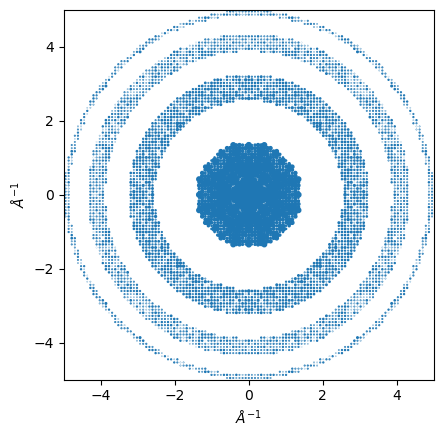

In [14]:
from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Lattice, Structure, Atom

a = 11.9
b = 11.9
c = 11.9
alpha = 90 
beta = 90 
gamma = 90

lattice = Lattice(a, b, c, alpha, beta, gamma)

# Define the phase using less atoms than in the pdb for computational reasons
atoms = [
    Atom("S", (0.869658, 0.683663, 0.500000), 0.5),
    Atom("O", (1.000000, 0.720240, 0.500000), 0.25),
    Atom("O", (0.796183, 0.796183, 0.500000), 0.25),
    Atom("O", (0.841263, 0.609813, 0.390187), 0.5),
         ]

# atoms = [Atom("C", (0, 0, 0), 1.0)]

"""
SI01  2    0.869658    0.683663    0.500000    10.50000    0.00414  
O002  1    1.000000    0.720240    0.500000    10.25000    0.01246  
O003  1    0.796183    0.796183    0.500000    10.25000    0.00763  
O004  1    0.841263    0.609813    0.390187    10.50000    0.02473 
"""

# Create the structure and corresponding phase
structure = Structure(atoms, lattice)
phase = Phase(space_group = 221, structure=structure)

# Sample orientations in the symmetry-reduced zone (resolution in degrees)
orientations = get_sample_reduced_fundamental(resolution=1, point_group=phase.point_group)

# Initialize the simulation generator (e.g., setting the accelerating voltage)
generator = SimulationGenerator(accelerating_voltage = 300, approximate_precession = False)
# Calculate 2D diffraction simulations using the provided phase and orientations
simulations = generator.calculate_diffraction2d(
    phase = phase,
    rotation = orientations,
    reciprocal_radius = 1/0.2,  # 1/Å (i.e. Å⁻¹)
    with_direct_beam = False,   # Include the direct beam
    max_excitation_error = 0.02, #0.04
    shape_factor_width = 1,
    debye_waller_factors = None,
    show_progressbar = True
)

# Plot the simulations
simulations.plot();

In [1]:
# Make sure plots display inline
%matplotlib inline
import os
import random
import h5py
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact
from helper_functions import copy_h5_file, get_next_simulation_folder, load_h5_data, view_image

# Specify the input HDF5 file
input_filename = "/Users/xiaodong/Desktop/simulations/LTA/100_empty_backgrounds.h5"
base_dir = os.path.dirname(input_filename)

# 1. Create a new simulation folder
new_sim_folder = get_next_simulation_folder(base_dir)

# 2. Copy the original file to the new simulation folder
output_filename = os.path.join(new_sim_folder, "sim.h5")
copy_h5_file(input_filename, output_filename)

# 3. Process the simulation images.
# Note: 'simulations' should be defined (or imported) before calling process_simulation.

intensity_scale = 1000
with h5py.File(output_filename, "r+") as data:
    images = data["entry"]["data"]["images"]
    euler_angles = data["entry"]["data"].require_dataset(
        "simulation_euler_angles", 
        shape=(images.shape[0], 3), 
        dtype=float
    )
    shape = images.shape[-2:]
    print(shape)
    for i in tqdm(range(images.shape[0]), desc="Processing images"):
        in_plane = random.uniform(0, 360)
        ind = random.randint(0, simulations.current_size - 1)
        img = simulations.irot[ind].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=(shape[0] // 2, shape[1] // 2),
            in_plane_angle=in_plane,
            sigma=1,
            calibration=0.00151, #0.0028445166816778583, 
            fast=False,
            normalize=True,
            fast_clip_threshold=1
        )
        img = (img * intensity_scale).astype(images.dtype)
        images[i] += img
        euler_angles_i = simulations.rotations[ind].to_euler(degrees=True).squeeze()
        euler_angles_i[0] = in_plane  # Override first Euler angle.
        euler_angles[i] = euler_angles_i
print("Processing complete. Updated file saved at:", output_filename)

# 4. Load the processed data for interactive visualization
images_arr, angles_arr = load_h5_data(output_filename)

# 5. Set up the interactive viewer
interact(lambda index: view_image(index, images_arr, angles_arr), 
         index=widgets.IntSlider(min=0, max=images_arr.shape[0]-1, step=1, value=0))


(1024, 1024)


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'simulations' is not defined